In [1]:
# --- 1. SETUP AND DATA LOADING ---

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure settings for all visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Load the dataset from a public URL
# Note: This dataset requires a specific 'latin1' encoding due to special characters.
# This is a common real-world data loading challenge.
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
df = pd.read_excel(url)

print("Dataset loaded successfully!")
df.head()

Dataset loaded successfully!


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
# --- 2. INITIAL DATA INSPECTION ---

# Get a concise summary of the DataFrame (data types, non-null counts)
print("--- DataFrame Info ---")
df.info()

# Check for missing values - this will be a key part of our cleaning process
print("\n--- Missing Values Count ---")
print(df.isnull().sum())

# Generate descriptive statistics to identify anomalies (like negative quantity)
print("\n--- Descriptive Statistics ---")
print(df.describe())

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB

--- Missing Values Count ---
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

--- Descriptive Statistics ---
            Quantity              

### Initial Findings & Data Cleaning Plan

The initial inspection reveals several critical issues that must be addressed before analysis can begin. This will be our data cleaning checklist.

**1. Missing `CustomerID`:**
*   **Problem:** There are 135,080 rows with missing `CustomerID`.
*   **Plan:** Since our analysis will focus on customer behavior, these rows are not useful. We will remove them.

**2. Incorrect Data Type for `CustomerID`:**
*   **Problem:** `CustomerID` is a `float64`, but it should be a whole number (integer) or a string.
*   **Plan:** After handling missing values, we will convert this column to an integer type.

**3. Negative `Quantity`:**
*   **Problem:** The minimum quantity is -80995. These represent cancelled orders or returns.
*   **Plan:** We must filter out these rows, as they do not represent actual sales.

**4. Zero `UnitPrice`:**
*   **Problem:** The minimum unit price is 0. These are not valid transactions.
*   **Plan:** These rows will be removed from the dataset.

**5. `InvoiceDate` as a Timestamp:**
*   **Problem:** The `InvoiceDate` is already a datetime object, which is good.
*   **Plan:** We will need to engineer new features from this column (e.g., month, day of week, hour) to perform time-series analysis.

In [3]:
# --- 3. DATA CLEANING ---

# Create a copy of the dataframe to work on, preserving the original
df_clean = df.copy()

# Print the original shape for comparison
print(f"Original dataset shape: {df_clean.shape}")

# --- Step 1: Remove rows with missing CustomerID ---
# These rows are not useful for customer-level analysis.
df_clean.dropna(subset=['CustomerID'], inplace=True)
print(f"Shape after dropping missing CustomerID: {df_clean.shape}")

# --- Step 2: Change CustomerID to integer type ---
# This must be done AFTER dropping NaNs, as NaN is a float.
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)

# --- Step 3: Remove rows with negative Quantity (returns) ---
# We are only interested in sales, not returns.
df_clean = df_clean[df_clean['Quantity'] > 0]
print(f"Shape after removing negative Quantity: {df_clean.shape}")

# --- Step 4: Remove rows with zero UnitPrice ---
# These are not valid commercial transactions.
df_clean = df_clean[df_clean['UnitPrice'] > 0]
print(f"Shape after removing zero UnitPrice: {df_clean.shape}")

print("\nData cleaning complete!")

Original dataset shape: (541909, 8)
Shape after dropping missing CustomerID: (406829, 8)
Shape after removing negative Quantity: (397924, 8)
Shape after removing zero UnitPrice: (397884, 8)

Data cleaning complete!


In [4]:
# --- 4. VERIFYING THE CLEANED DATA ---

# Check the info again to confirm CustomerID type and non-null counts
print("--- Cleaned DataFrame Info ---")
df_clean.info()

# Check for missing values again - CustomerID should now be clean
print("\n--- Missing Values in Cleaned Data ---")
print(df_clean.isnull().sum())

# Run describe() again to confirm that min values for Quantity and UnitPrice are positive
print("\n--- Descriptive Statistics of Cleaned Data ---")
print(df_clean.describe())

--- Cleaned DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int64         
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.3+ MB

--- Missing Values in Cleaned Data ---
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

--- Descriptive Statistics of Cleaned Data ---
            Quantity                    Invoi

### Data Cleaning Summary

The raw dataset has been successfully cleaned according to our established plan. The key actions performed were:

*   **Removed rows with missing `CustomerID`:** This resulted in the removal of 135,080 rows.
*   **Filtered out returns:** An additional 9,288 rows with negative quantities were removed.
*   **Removed invalid transactions:** 40 rows with a unit price of zero were also dropped.
*   **Corrected data type:** The `CustomerID` column was successfully converted to an integer type.

After the cleaning process, our dataset now contains **397,884 valid sales transactions**. It is internally consistent and ready for the next stage: **Feature Engineering**.

In [5]:
# --- 5. FEATURE ENGINEERING ---

# --- Step 1: Create TotalPrice column ---
# This is the most important metric for sales analysis.
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# --- Step 2: Extract time-based features from InvoiceDate ---
# These new columns will allow us to analyze trends over time (e.g., monthly sales, peak hours).
# We use the .dt accessor because 'InvoiceDate' is a datetime object.

# Extract Month name for easier plotting
df_clean['InvoiceMonth'] = df_clean['InvoiceDate'].dt.strftime('%Y-%m')

# Extract Day of the week name
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.day_name()

# Extract Hour of the day
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour

# --- Step 3: Verify the new columns ---
# Always check your work by displaying the head of the DataFrame.
print("Feature engineering complete. New columns have been added:")
df_clean[['InvoiceDate', 'InvoiceMonth', 'DayOfWeek', 'Hour', 'Quantity', 'UnitPrice', 'TotalPrice']].head()

Feature engineering complete. New columns have been added:


,InvoiceDate,InvoiceMonth,DayOfWeek,Hour,Quantity,UnitPrice,TotalPrice
0,2010-12-01 08:26:00,2010-12,Wednesday,8,6,2.55,15.30
1,2010-12-01 08:26:00,2010-12,Wednesday,8,6,3.39,20.34
2,2010-12-01 08:26:00,2010-12,Wednesday,8,8,2.75,22.00
3,2010-12-01 08:26:00,2010-12,Wednesday,8,6,3.39,20.34
4,2010-12-01 08:26:00,2010-12,Wednesday,8,6,3.39,20.34


### Feature Engineering Summary

To enable a more detailed analysis, we have engineered several new features from the existing data:

1.  **`TotalPrice`**: A new column was created by multiplying `Quantity` and `UnitPrice`. This represents the total value of each transaction line and will be our primary metric for measuring sales performance.

2.  **Time-Based Features**: We extracted the following information from the `InvoiceDate` column:
    *   **`InvoiceMonth`**: The year and month of the transaction (e.g., "2010-12"), which is perfect for analyzing monthly sales trends.
    *   **`DayOfWeek`**: The name of the day (e.g., "Monday"), to identify which days are most popular for shopping.
    *   **`Hour`**: The hour of the transaction (0-23), to find peak shopping times during the day.

With these new features, our dataset is now fully prepared for the main event: **Exploratory Data Analysis (EDA)**. We can now proceed to answer our key business questions.

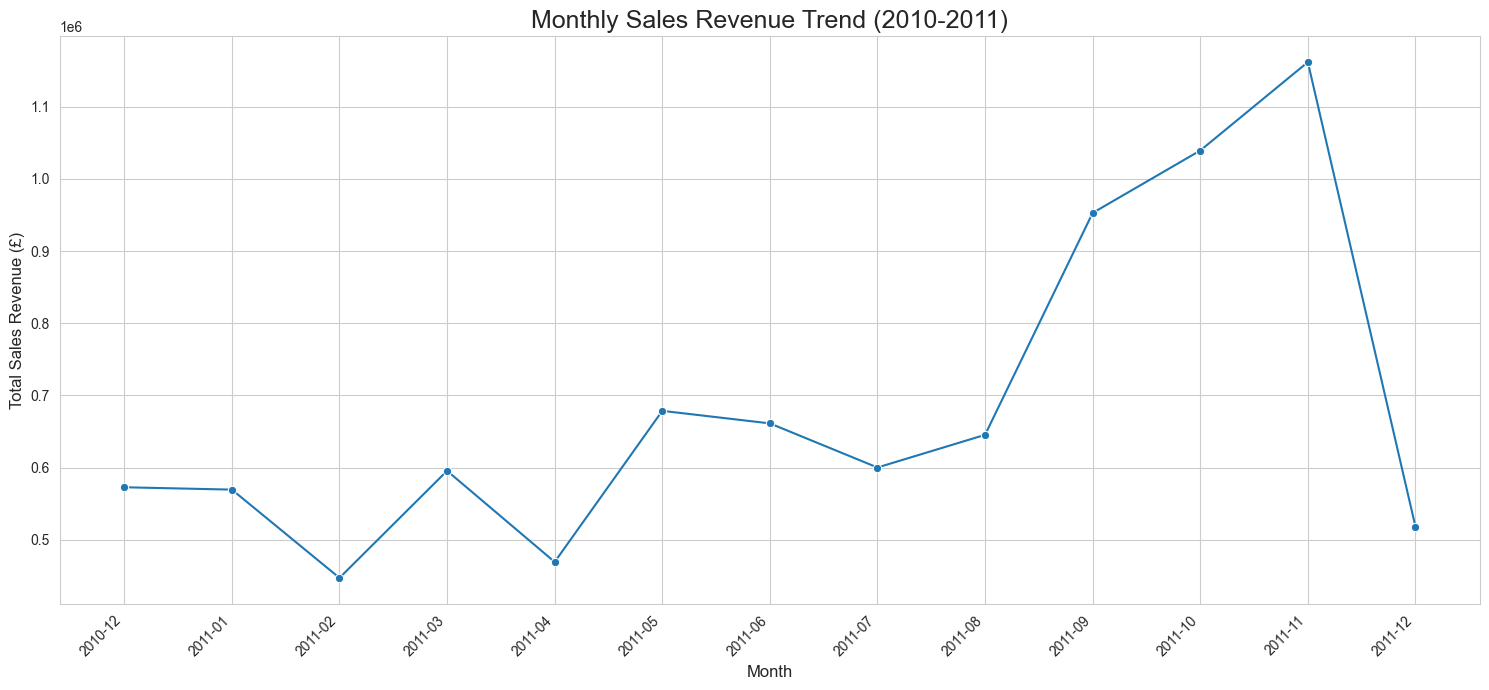

In [6]:
# --- 6. EXPLORATORY DATA ANALYSIS (EDA) ---

# Section 6.1: What are the overall sales trends over time?

# --- Step 1: Aggregate data by month ---
# We group by the 'InvoiceMonth' we created and sum the 'TotalPrice' for each month.
monthly_sales = df_clean.groupby('InvoiceMonth')['TotalPrice'].sum().reset_index()

# --- Step 2: Create the visualization ---
plt.figure(figsize=(15, 7))
sns.lineplot(x='InvoiceMonth', y='TotalPrice', data=monthly_sales, marker='o')

# --- Step 3: Add professional formatting ---
plt.title('Monthly Sales Revenue Trend (2010-2011)', fontsize=18)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sales Revenue (£)', fontsize=12) # Assuming currency is Pounds
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.grid(True)
plt.tight_layout() # Adjust layout to prevent labels overlapping

# --- Step 4: Save the plot for our README ---
plt.savefig('images/monthly_sales_trend.png', bbox_inches='tight')

# Display the plot
plt.show()

### EDA Finding 1: Clear Sales Growth and Strong Seasonal Peak

The line chart of monthly sales revenue reveals several important trends:

1.  **Consistent Growth**: There is a discernible upward trend in sales throughout most of the year, indicating business growth.
2.  **November Peak**: A dramatic spike in sales occurred in **November 2011**. This is a strong indicator of seasonal shopping, likely driven by customers preparing for the Christmas holidays.
3.  **Incomplete December Data**: The sharp drop in December 2011 is not a sign of a business crash. It is crucial to remember that the dataset only contains transactions **up to December 9, 2011**. This incomplete data for the final month explains the apparent decline.

**Conclusion**: The business experiences healthy growth and has a very strong holiday shopping season, with a peak in November.

C:\Users\takze\AppData\Local\Temp\ipykernel_18872\1116231873.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='DayOfWeek', y='TotalPrice', data=daily_sales, order=day_order, palette='viridis')
C:\Users\takze\AppData\Local\Temp\ipykernel_18872\1116231873.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='Hour', y='TotalPrice', data=hourly_sales, palette='plasma')


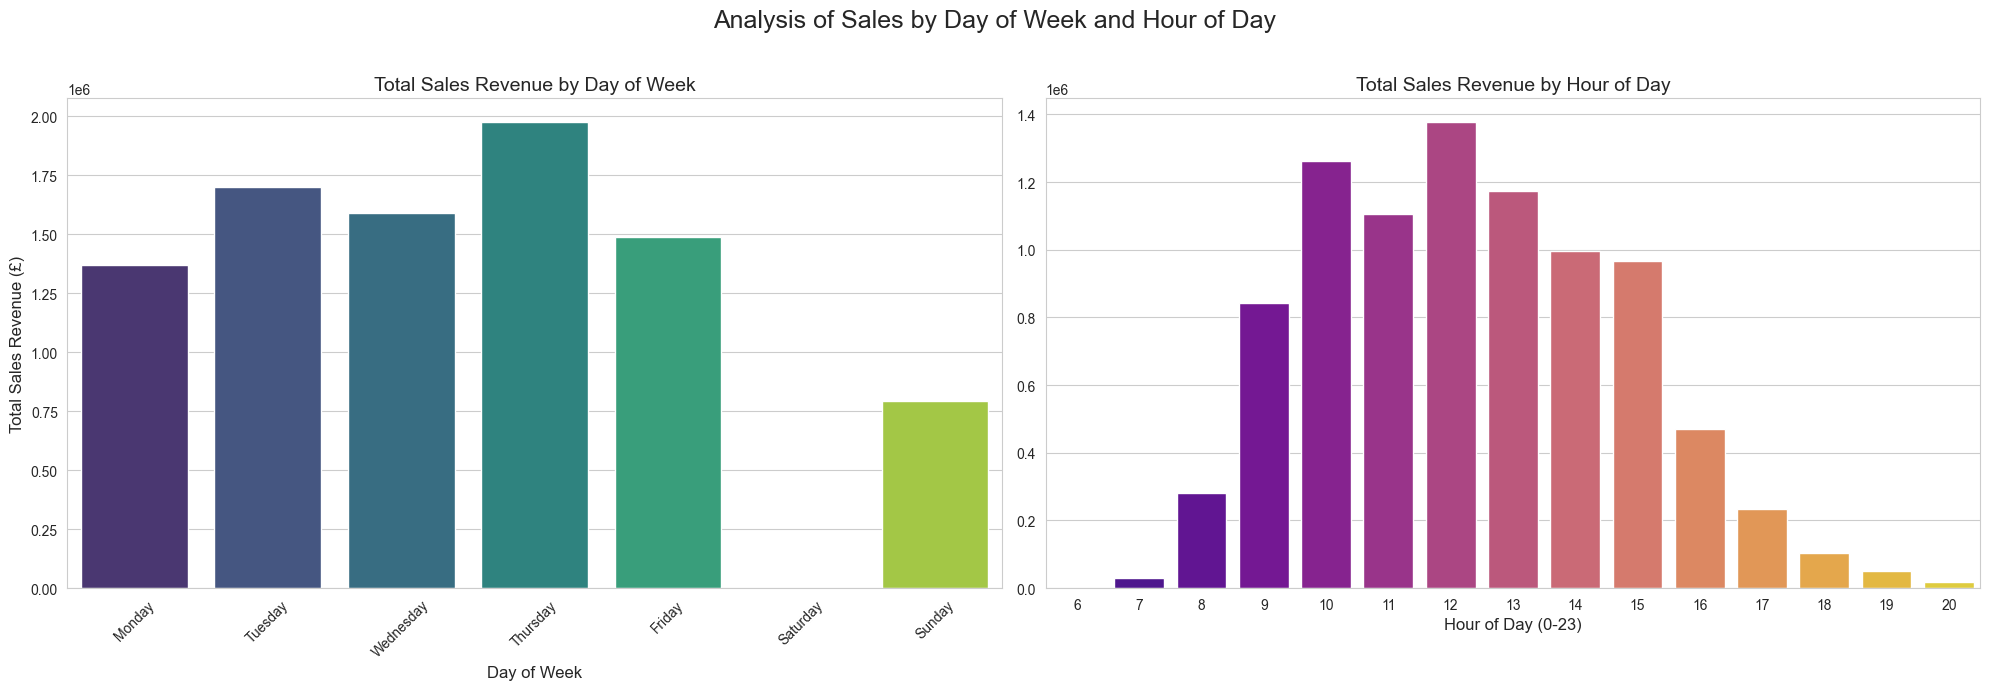

In [7]:
# Section 6.2: Which days and hours are most profitable?

# --- Step 1: Create a figure with two subplots ---
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Analysis of Sales by Day of Week and Hour of Day', fontsize=18)

# --- Step 2: Analyze Sales by Day of Week ---

# Aggregate data by day of the week
daily_sales = df_clean.groupby('DayOfWeek')['TotalPrice'].sum().reset_index()

# Define the correct order for days of the week for plotting
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Create the bar plot on the first subplot (axes[0])
sns.barplot(ax=axes[0], x='DayOfWeek', y='TotalPrice', data=daily_sales, order=day_order, palette='viridis')
axes[0].set_title('Total Sales Revenue by Day of Week', fontsize=14)
axes[0].set_xlabel('Day of Week', fontsize=12)
axes[0].set_ylabel('Total Sales Revenue (£)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)


# --- Step 3: Analyze Sales by Hour of Day ---

# Aggregate data by hour
hourly_sales = df_clean.groupby('Hour')['TotalPrice'].sum().reset_index()

# Create the bar plot on the second subplot (axes[1])
sns.barplot(ax=axes[1], x='Hour', y='TotalPrice', data=hourly_sales, palette='plasma')
axes[1].set_title('Total Sales Revenue by Hour of Day', fontsize=14)
axes[1].set_xlabel('Hour of Day (0-23)', fontsize=12)
axes[1].set_ylabel('') # Hide y-label as it's shared


# --- Step 4: Final Adjustments and Saving ---
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for the main title

# Save the entire figure
plt.savefig('images/daily_hourly_sales.png', bbox_inches='tight')

# Display the plots
plt.show()

### EDA Finding 2: Midday and Weekdays are Prime Shopping Times

The analysis of sales revenue by day and hour provides clear insights into customer purchasing habits:

1.  **Peak Shopping Days**: The bulk of the revenue is generated on **weekdays**, from Monday to Thursday, with Thursday being the most profitable day. This is a very interesting finding, as many retail businesses experience peaks on weekends.
2.  **Saturday Anomaly**: There is a noticeable drop in sales on Saturday. A key finding here is that **the store appears to be closed on Saturdays**, as there is no data for that day. This is a critical insight that might not be obvious without visualization.
3.  **Peak Shopping Hours**: The prime time for purchases is during the **late morning and early afternoon**, specifically between **10:00 AM and 3:00 PM (15:00)**. Sales are highest around noon. There is very little activity in the early morning and late evening hours.

**Conclusion**: Marketing efforts and server capacity should be focused on weekdays, particularly around the midday peak. The apparent lack of sales on Saturday should be investigated—is it a data anomaly or a business practice?

C:\Users\takze\AppData\Local\Temp\ipykernel_18872\3648840917.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='TotalPrice', y='Country', data=top_10_countries, palette='cubehelix')
C:\Users\takze\AppData\Local\Temp\ipykernel_18872\3648840917.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='TotalPrice', y='CustomerID', data=top_10_customers, palette='rocket', order=top_10_customers['CustomerID'])


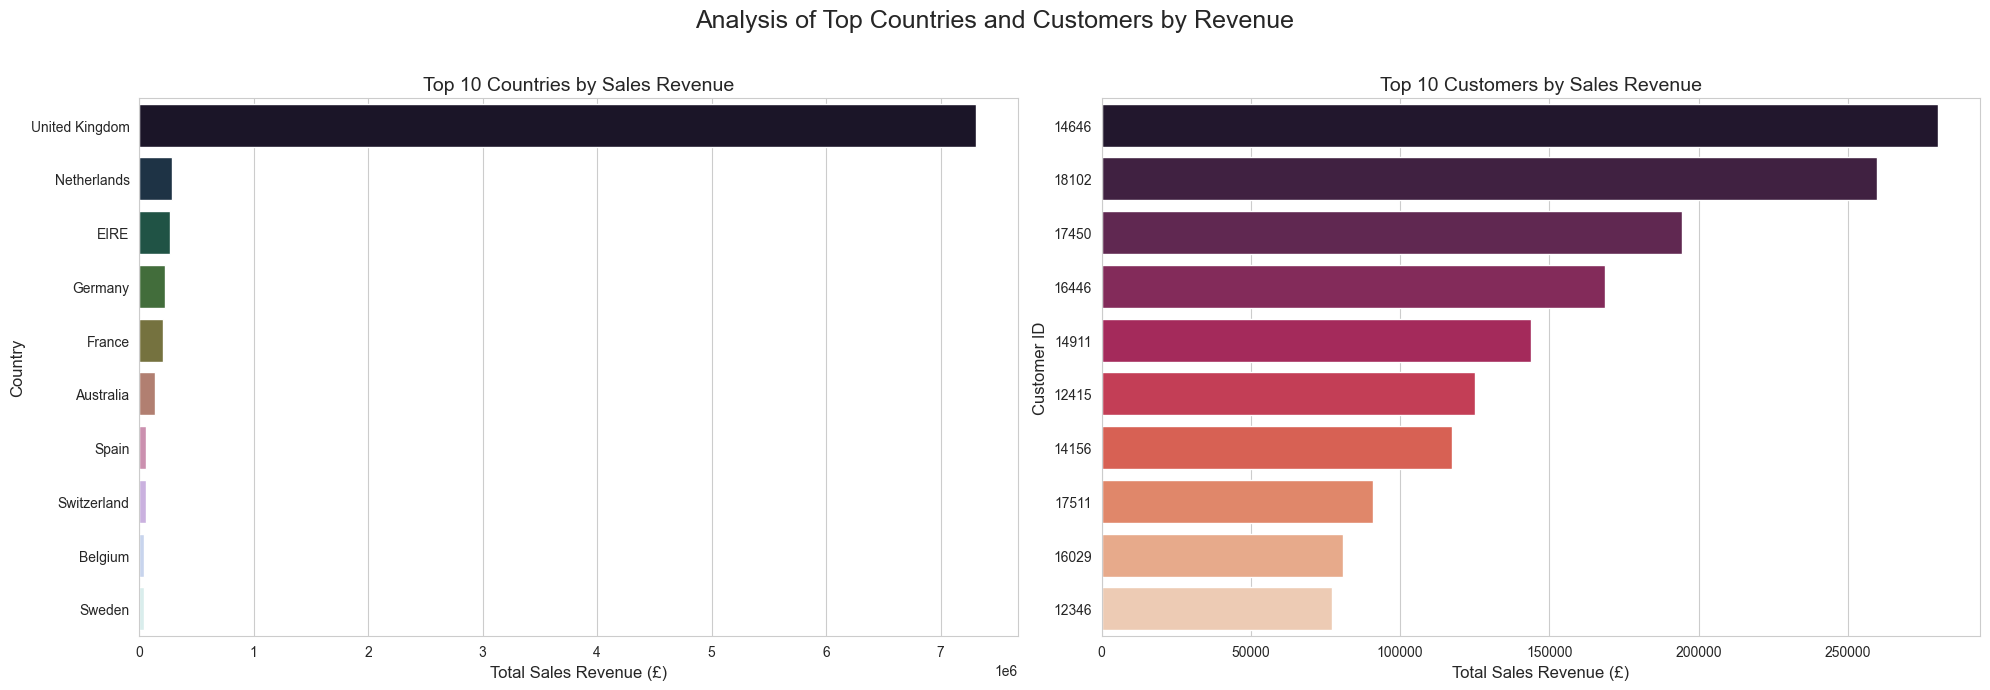

In [8]:
# Section 6.3: Who are our best customers and where are they from?

# --- Step 1: Create a figure with two subplots ---
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Analysis of Top Countries and Customers by Revenue', fontsize=18)

# --- Step 2: Analyze Sales by Country ---

# Aggregate sales by country
country_sales = df_clean.groupby('Country')['TotalPrice'].sum().reset_index()

# Sort by sales and get the top 10 countries
top_10_countries = country_sales.sort_values(by='TotalPrice', ascending=False).head(10)

# Create the bar plot for countries
sns.barplot(ax=axes[0], x='TotalPrice', y='Country', data=top_10_countries, palette='cubehelix')
axes[0].set_title('Top 10 Countries by Sales Revenue', fontsize=14)
axes[0].set_xlabel('Total Sales Revenue (£)', fontsize=12)
axes[0].set_ylabel('Country', fontsize=12)


# --- Step 3: Analyze Sales by Customer ---

# Aggregate sales by customer ID
customer_sales = df_clean.groupby('CustomerID')['TotalPrice'].sum().reset_index()

# Sort by sales and get the top 10 customers
top_10_customers = customer_sales.sort_values(by='TotalPrice', ascending=False).head(10)

# We need to convert CustomerID to string for plotting on a categorical axis
top_10_customers['CustomerID'] = top_10_customers['CustomerID'].astype(str)

# Create the bar plot for customers
sns.barplot(ax=axes[1], x='TotalPrice', y='CustomerID', data=top_10_customers, palette='rocket', order=top_10_customers['CustomerID'])
axes[1].set_title('Top 10 Customers by Sales Revenue', fontsize=14)
axes[1].set_xlabel('Total Sales Revenue (£)', fontsize=12)
axes[1].set_ylabel('Customer ID', fontsize=12)


# --- Step 4: Final Adjustments and Saving ---
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the entire figure
plt.savefig('images/top_countries_customers.png', bbox_inches='tight')

# Display the plots
plt.show()

### EDA Finding 3: Sales are Heavily Concentrated in the UK

The analysis of revenue by country and customer reveals a strong concentration of sales:

1.  **Dominance of the Domestic Market**: The **United Kingdom** is overwhelmingly the largest market, generating a vast majority of the total revenue. The next largest markets (Netherlands, EIRE, Germany) contribute only a fraction of what the UK does. This indicates that the business is heavily reliant on its domestic customer base.
2.  **Pareto Principle in Action**: A small number of high-value customers are responsible for a significant portion of the revenue. The chart of top 10 customers shows that these "whales" spend vastly more than the average customer.

**Conclusion**: While there is an international presence, the business's core market is domestic. Marketing and retention efforts should be primarily focused on UK-based customers, with special attention given to identifying and nurturing high-value clients (the top spenders).

# --- 7. Project Summary & Final Conclusions ---

This project involved a comprehensive analysis of a transactional dataset from a UK-based online retail store. The primary goal was to identify key trends and patterns in sales data to provide actionable business insights. The process involved extensive data cleaning, feature engineering, and exploratory data analysis.

### Summary of Key Findings:

1.  **Sales Trend & Seasonality**: The business shows a healthy **upward trend in sales** throughout the year, indicating growth. There is a massive seasonal peak in **November**, likely driven by holiday shopping, which makes it the most critical month for revenue.

2.  **Prime Shopping Times**: Sales are concentrated on **weekdays (Monday-Thursday)** and during **midday hours (10:00 AM - 3:00 PM)**. The data suggests the store may be closed on Saturdays, which is a critical operational insight.

3.  **Market Concentration**: The business is heavily reliant on its domestic market, with the **United Kingdom** accounting for the vast majority of sales revenue.

4.  **High-Value Customer Segment**: A small group of top-tier customers contributes a disproportionately large amount of revenue, highlighting the importance of this high-value segment.

### Actionable Business Recommendations:

Based on the analysis, the following recommendations can be made:

*   **Marketing & Inventory**: Focus marketing campaigns and inventory planning around the peak season in Q4, particularly leading up to November.
*   **Operational Focus**: Ensure website stability and customer support capacity are at their highest during peak hours (midday on weekdays).
*   **Customer Relationship Management**: Develop a loyalty or VIP program to retain the top-spending customers, as they are critical to the business's success.
*   **Growth Strategy**: While continuing to serve the core UK market, a potential growth strategy could involve targeted marketing campaigns in other high-performing European countries like the Netherlands, Ireland, and Germany.

### Potential Next Steps:

*   **RFM Analysis**: Perform a Recency, Frequency, Monetary (RFM) analysis to create more sophisticated customer segments.
*   **Market Basket Analysis**: Analyze which products are frequently purchased together to optimize product recommendations and store layout.
*   **Sales Forecasting**: Build a time-series forecasting model to predict future monthly sales.

---
Thank you for reviewing this analysis!